In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Ensemble Learning
# - aggregate the predictions of a groups of predictors -> often leads to better prediction than only with one best predictor
# - Ensemble learning algorihm - called Ensemble method

# E.g. can train a group of DT classifiers, each on a different random subset of the training set
# - to make a prediction - predicts the class that gets the most votes 
# -> such ensemble of DTs: Random Forest - very simple but one of the most powerful ML algorithms

In [3]:
# Voting Classifiers
# create multiple classifiers and aggregate the predictions of each classifier and predict the class that gets the most votes
# -> called hard voting classifier

# often achieves a higher accuracy than the best classifier in the ensemble
# even if each classifier is a weak learner (slightly better than random guessing) - the ensemble cans till be a strong learner (given enough classifiers)
# works due to the law of large numbers

In [4]:
# Creating and trainng a voting classifier in Scikit-Learn:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [5]:
# Accuracy of each classifier on the test set:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


In [6]:
# Voting classifier slighlty outperforms all individual classifiers

In [7]:
# Soft voting:
# - if all classifiers can estimate class probabilities (i.e. predict_prob() method)
# - Scikit-Learn allows you to predict the class with the highest probability, averaged over all the individual classifiers (soft voting)
# often better than hard voting, since it gives more weight to highly confident votes - replace voting="hard" to voting="soft":

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [9]:
# The prediction accuracy jumpted to 92%
# Make sure all classifiers can estimate class probabilities -> not the case for SVC by default
# -> set probability hyperparameter to true

In [10]:
# Bagging and Pasting
# Different approach to diversify classifiers:
# - use same training algorithm for every predictor, but train them on different random subsets of the training set
# - if you sample with replacement (sample can be selected more than once for one predictor) - called bagging (short for bootstrap aggregating)
# - if no replacement (sample can be selected only once for one predictor) - called pasting

# Once all predictors are trained - an ensemble can make a prediction for a new instance by simply aggregating all predictions
# - aggregation function is typically the statistical mode, i.e. the most frequent predicition, just like a hard voting classifier, for classification
#   or the average for regression

# Each individual predictor - higher bias than if trained on the whole training set but aggregation reduces both BIAS and VARIANCE
# Generally, net result: ensemble has similar bias but lower variance than a single predictor trained on the original training set

# One can train multiple predictors in parallel, via different CPU cores
# Similarly - predictions can also be made in parallel - they scale well (which makes them popular)

In [11]:
# Example using Scikit-Learn
# Let's train 500 DT classifiers, each trained on 100 training instnace randomly sampled from the training set - bagging
# (to do pasting - set bootstrap=False)
# n_jobs param tells how many CPU cores to use for training and predictions - -1 means to use all available cores
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [12]:
# BaggingClassifier automatically performed soft voting insted of hard if the base classifier can estimate probabilities - true for DTs
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.912


In [13]:
# Compare to a single DT:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

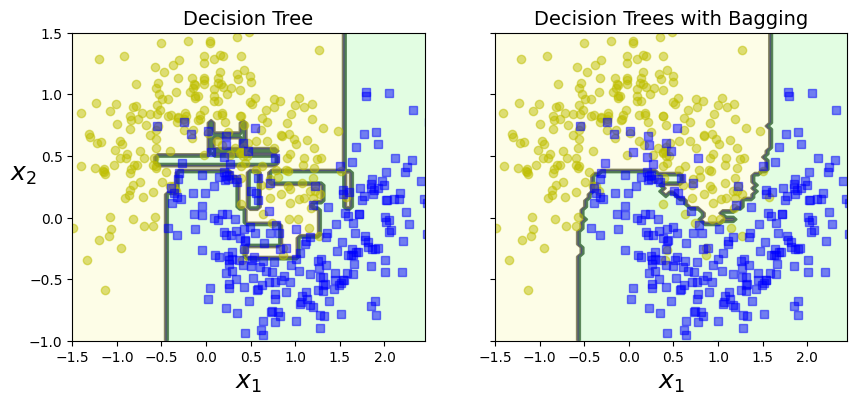

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

In [16]:
# Example of decision boundaries - single DT (left) vs Ensemble of DTs using bagging on moons dataset
# - ensemble's predictions will probably generalize better 
# - ensemble has comparable bias but smaller variance 
# (it roughly makes the same number of errors on the training set, but the decision boundary is less irregular)

In [17]:
# Bootstrapping introductes a bit more diversity in the subsets that each predictor is trained on
# thus, bagging ens up with a slighlty higher bias than pasting
# However, this means that predictors end up being less correlated so the ensemble's variance is reduced

# In general, bagging often results in better models - therefore it is usually perferred
# But if you have spare time and CPU power - do cross-validation and evaluate both bagging and pasting to see what works best

In [18]:
# Out-of-Bag Evaluation
# with bagging - some instance may be sampled several times while others may not be sampled at all for any given predictor
# by default - samples m training instances with replacement (m s the size of the training set)
# -> only about 63% of training instances are sampled on average for each predictor
# - the rest 37% which are not sampled are colled out-of-bag (oob) instances
# -- note: they are not the same 37% for all predictors

# Since the predictor never sees the oob instances - one can use them for evaluation without the need for a separate validation set
# can evaluate the ensemble itself by averaging out the oob evaluations for each predictor

In [19]:
# Scikit-Learn - can set oob_score = True when creating BaggingClassifier to request an automatic oob evaluation after training
# Example:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True)

In [20]:
bag_clf.oob_score_

0.8986666666666666

In [21]:
# According to the oob_score - BaggingClassifier is likely to achieve almost 90% accuracy on the test set:
# Let's see:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [22]:
# oob decision function for each training instance is also available
# in this case - it returns class probabilities for each training instance (e.g. 58.1% prob of belonging to the positive class)
bag_clf.oob_decision_function_

array([[0.41899441, 0.58100559],
       [0.35502959, 0.64497041],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07909605, 0.92090395],
       [0.36144578, 0.63855422],
       [0.01578947, 0.98421053],
       [0.98285714, 0.01714286],
       [0.97927461, 0.02072539],
       [0.78165939, 0.21834061],
       [0.00578035, 0.99421965],
       [0.71052632, 0.28947368],
       [0.7967033 , 0.2032967 ],
       [0.96111111, 0.03888889],
       [0.05789474, 0.94210526],
       [0.        , 1.        ],
       [0.98461538, 0.01538462],
       [0.93548387, 0.06451613],
       [1.        , 0.        ],
       [0.00591716, 0.99408284],
       [0.36206897, 0.63793103],
       [0.92670157, 0.07329843],
       [1.        , 0.        ],
       [0.99465241, 0.00534759],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64878049, 0.35121951],
       [0.

In [23]:
# Random Patches and Random Subspaces
# BaggingClassifier - supports sampling the features as well - controlled by two params:
# - max_features and bootstrap_features - for feature sampling insteade of instance sampling
# -> can train a predictor based on a random subset of the input features

# Useful when dealing with high-dimensional inputs such as images
# If you sample both training instances and features -> Random Patches metod
# Keeping all training instances (bootstrap=False, max_samples=1.0) but sampling features (bootstrap_features=True, max_features < 1.0)
# -> Random Subspaces method

# Results in even more predictor diversity - trading a bit more bias for lower variance

In [24]:
# Random Forests
# Ensemble of DTs - generally trained via the bagging method, typically max_samples=size of the training set
# Instead of using BaggingClassifier and passing it a DTClassifier:
# - use RandomForestClassifier class: more convenient and optimized for DTs

In [25]:
# Example of training Random Forest classifier with 500 trees (each limited to max. 16 nodes) using all cpu cores
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [26]:
# Random forest is equivialent to a bag od DTs
from sklearn.ensemble import RandomForestClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [27]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

np.float64(0.992)

In [28]:
# RF introduces extra randomness when growing trees;
# instead of searching for the very best feature when splitting a node, it searches for a best features among a random subset of features
# - results in a greater tree diversity - trades a higher bias for a lower variance, generally yielding an overall better model

In [29]:
# Extra trees
# possible to make the trees even more random by using random thresholds for each features rather than searching for the best possible threshold
# -> Extremely Randomized Trees ensemble - again more bias for lower variance
# - faster to train than regular RF - finding the best possible threshold for each features is the most time-consuming task of growing a tree
# - Extra-Trees can be creatued using ExtraTreesClassifier - API identical to RandomForestClassifier
# - hard to know which model will perform better in advance - best to try both and compare them

In [30]:
# Feature importance
# RFs - make it easy to measure the relative importance of each feature
# Scikit-Learn: looks at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest)
# - weighted average - node's weight = number of training samples associated with it

# Scikit-Learn computs this score automatically for each feature after training, and then scales the results so that the sum ofll importances = 1
# - can be accessed using feature_importances_ variable

In [31]:
# Let's see it on the Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [32]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

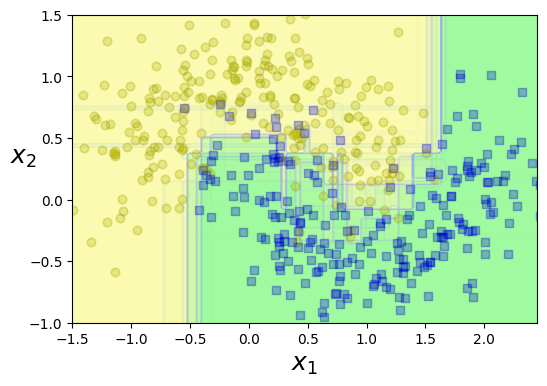

In [33]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [34]:
# Above image - overlays decision boundaries of 15 DTS
# ALtho each DT is imperfect - emseble defines a quite good decision boundary

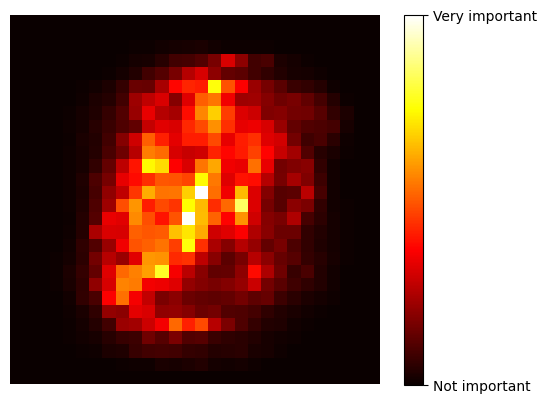

In [37]:
# Feature importance on MNIST dataset - pixel importance
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

In [38]:
# Boosting
# - refers to any Ensemble method that con combine several weak learners into a strong learner
# - train predictors sequentially, each trying to corrects its predecessor
# - many methods available- the most popular ones: AdaBoost (Adaptive Boosting) & Gradient Boosting

In [39]:
# AdaBoost:
# - correct its predecessor by paying a bit more attention to the training instances that the predecessor underfittet
# -> results in new predictors focusing more and more on the hard cases

# Example: 1) first a base Classifier (e.g. DT) - trained and used to make predictions on the training set
# 2) the relative weight of misclassified training instances is then increased
# 3) a second classifier is trained using the updated weights and again it makes predictions on the training set -> update the weights
# 4) repreat

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

C:\Users\ge85diz\OneDrive - TUM\TUM_Documents\TUM\Education\ml_review\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

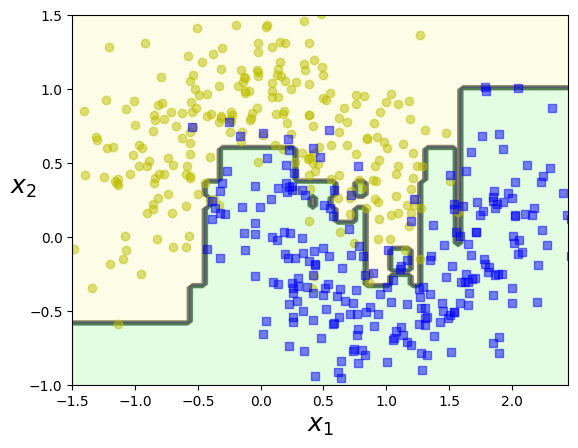

In [41]:
plot_decision_boundary(ada_clf, X, y)

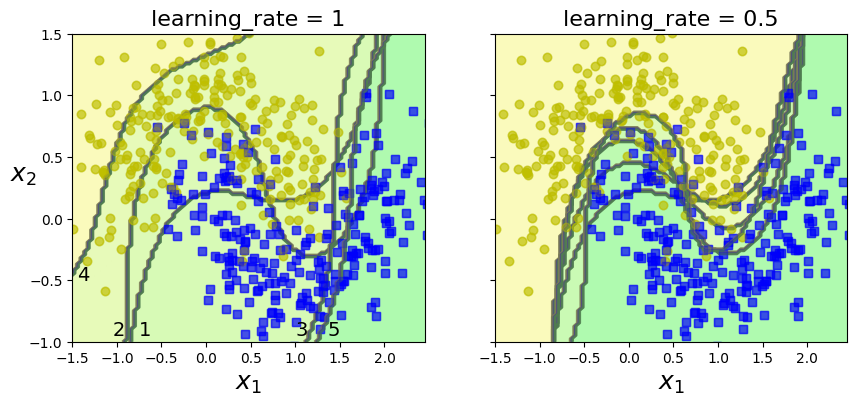

In [42]:
# Decision boundaries of consecutive predictors:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

In [43]:
# Above is the decision boundaries of 5 consecutive predictors on the moons dataset - each predictor: highly regularized SVM classifier (RBF kernel)
# (usually not the best to use SVM as base predictors for AdaBoost - slow and tend to be unstable with AdaBoost)
# - the first classifier gets many instances wrong -> their weights get bootsted
# - second classifer does a better job and so on

# Right plot - lower learning rate -> misclassified instance weights are boosted half as much at every iteration
# Sequential learning technique has some similarities with Gradient Descent,
# but instead of tweaking a single predictor's params to minimize the cost function, AdaBoost adds predictors to the ensemble
# -> which makes it gradually better

In [44]:
# Once all predidtors are trained, the ensemble makes predictors very much like bagging or pasting,
# except that predictors have different weights depening on their overall accuracy on the weighted training set
# Maths behind the scenes are explained on p. 203 & 204

# Drawback - sequential learning technique - cannot be parallelized, since each predictor can only be trained after the previous finishes
# - does not scale well was bagging or pasting

In [45]:
# Scikit-Learn uses a multiclass version of AdaBoost - called SAMME (Stagewise Additive Modelling using a Multiclass Exponential Loss function)
# when only two classes - SAMME = AdaBoost
# If predictors can estimate class probabilities -> Scikit-Learn uses variant of SAMME called SAMMER (R - real)
# - relies on class probabilities rather than predictions and generally performs better

In [ ]:
# Decision Stump = Decision Tree with max_depth = 1: Tree composed of a single decision node plus two leaf nodes
# If AdaBoost ensemble is overfitting - can try reducing the number of estimators or more strongly regularizing the base estimator